In [26]:
import numpy as np
import cvxpy as cp
import itertools as it
import scipy.linalg as spla
import matplotlib.pyplot as plt
import pennylane as qml

Basic functions and utils

In [569]:
def pauli_basis(n):
    I = np.eye(2).astype(complex)
    X = np.array([[0, 1], [1, 0]], complex)
    Y = np.array([[0, -1j], [1j, 0]], complex)
    Z = np.array([[1, 0], [0, -1]], complex)
    basis = {
        "labels": [],
    }
    b = []
    for comb in list(it.product([0, 1, 2, 3], repeat=n))[1:]:
        p = 1.
        basis["labels"].append(comb)
        for c in comb:
            if c == 0:
                p = np.kron(p, I)
            elif c == 1:
                p = np.kron(p, X)
            elif c == 2:
                p = np.kron(p, Y)
            elif c == 3:
                p = np.kron(p, Z)
        b.append(p)
    basis["basis"] = np.stack(b)
    return basis

def two_body_projection_indices(basis):
    basis_indices = []
    for i, b in enumerate(basis["labels"]):
        if len(np.nonzero(b)[0]) <= 2:
            basis_indices.append(1)
        else:
            basis_indices.append(0)
    return basis_indices

def two_body_projection(theta, basis):
    indices = two_body_projection_indices(basis)
    return np.array([t * indices[i] for i,t in enumerate(theta)])
    
def two_body_restriction_basis(basis):
    new_basis = {
        "labels": [],
    }
    basis_elements = []
    for i, b in enumerate(basis["labels"]):
        if len(np.nonzero(b)[0]) <= 2:
            new_basis["labels"].append(b)
            basis_elements.append(np.array(basis["basis"][i]))
    new_basis["basis"] = np.stack(basis_elements)
    return new_basis

def specific_basis_terms(basis, specific_labels, ts):
    theta = []
    for l in basis["labels"]:
        if l in specific_labels:
            theta.append(ts[specific_labels.index(l)])
        else:
            theta.append(0)
    return np.array(theta)
    
def hamiltonian_from_parameters(parameters, basis):
    return np.einsum("ijk,i->jk", basis, parameters)

def unitary_from_parameters(parameters, basis):
    h = hamiltonian_from_parameters(parameters, basis)
    return spla.expm(1.j*h)

def parameters_from_hamiltonian(hamiltonian, basis):
    return np.real(np.einsum("ijk, kj->i", basis, hamiltonian)) / (len(hamiltonian[0]))

def unitary_fidelity(U1, U2):
    return np.abs(np.trace(U1.conj().T @ U2))/len(U1[0])

def phi_fidelity(phi, phi_basis, U2):
    phi_H = hamiltonian_from_parameters(phi, phi_basis)
    phi_U = spla.expm(1.j * phi_H)
    return unitary_fidelity(phi_U, U2)
    
# def geodesic_ham(U, V):
#     gamma = -1.j * spla.logm(V @ U.conj().T)
#     return gamma

def geodesic_ham(U, V):
    gamma = -1.j * spla.logm(U.conj().T @ V)
    return gamma

def commutator(A, B):
    return (A @ B) - (B @ A)

def trace_norm(A, B=None):
    if B is None:
        norm = np.trace(A.conj().T @ A)
    else:
        norm = np.trace(A.conj().T @ B)
    return norm
    
def plot_parameters(labels, parameters, title=False, figsize=[14,6]):
    labels = ["".join(map(str, l)) for l in labels]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(labels,parameters)
    ax.grid()
    if title:
        plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
    
def plot_fidelities(steps, fidelities, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    ax.plot(steps, fidelities)
    if title:
        plt.title(title)
    plt.show()
    
def plot_multi_fidelities(multi_steps, multi_fidelities, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    for i, fidelities in enumerate(multi_fidelities):
        fid = [1 - f for f in fidelities] 
        ax.plot(multi_steps[i], fid)
    if title:
        plt.title(title)
    ax.set_yscale('log')
    ax.set_xlabel("Step")
    ax.set_ylabel("1 - fidelity")
    plt.show()
    
def plot_multi_step_sizes(multi_steps, multi_step_sizes, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    for i, s in enumerate(multi_step_sizes):
        ax.plot(multi_steps[i], s)
    if title:
        plt.title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Step size")
    plt.show()

def plot_direction_indices(indices, title=False):
    plt.hist(indices, bins=len(indices))
    if title:
        plt.title(title)
    plt.show()

Step size map, convex optimisation for linear combination of omegas, and constructing new phi vectors

In [570]:
invphi = (np.sqrt(5) - 1) / 2  # 1 / phi
invphi2 = (3 - np.sqrt(5)) / 2  # 1 / phi^2

def golden_section_search(f, a, b, tol=1e-5):
    """Golden-section search.

    Given a function f with a single local minimum in
    the interval [a,b], gss returns a subset interval
    [c,d] that contains the minimum with d-c <= tol.
    
    Example:
    f = lambda x: (x-2)**2
    a = 1
    b = 5
    tol = 1e-5
    (c,d) = gss(f, a, b, tol)
    print(c, d)
    1.9999959837979107 2.0000050911830893
    source: https://en.wikipedia.org/wiki/Golden-section_search
    """

    (a, b) = (min(a, b), max(a, b))
    h = b - a
    if h <= tol:
        return (a, b)

    # Required steps to achieve tolerance
    n = int(np.ceil(np.log(tol / h) / np.log(invphi)))
    
    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)
    
    for k in range(n-1):
        if yc < yd:  # yc > yd to find the maximum
            b = d
            d = c
            yd = yc
            h = invphi * h
            c = a + invphi2 * h
            yc = f(c)
        else:
            a = c
            c = d
            yc = yd
            h = invphi * h
            d = a + invphi * h
            yd = f(d)
    if yc < yd:
        return (a, d), yc
    else:
        return (c, b), yd

def golden_section_search(f, a, b, tol=1e-5):
    """Golden-section search.

    Given a function f with a single local minimum in
    the interval [a,b], gss returns a subset interval
    [c,d] that contains the minimum with d-c <= tol.
    
    Example:
    f = lambda x: (x-2)**2
    a = 1
    b = 5
    tol = 1e-5
    (c,d) = gss(f, a, b, tol)
    print(c, d)
    1.9999959837979107 2.0000050911830893
    source: https://en.wikipedia.org/wiki/Golden-section_search
    """

    (a, b) = (min(a, b), max(a, b))
    h = b - a
    if h <= tol:
        return (a, b)

    # Required steps to achieve tolerance
    n = int(np.ceil(np.log(tol / h) / np.log(invphi)))
    
    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)
    
    for k in range(n-1):
        if yc > yd: 
            b = d
            d = c
            yd = yc
            h = invphi * h
            c = a + invphi2 * h
            yc = f(c)
        else:
            a = c
            c = d
            yc = yd
            h = invphi * h
            d = a + invphi * h
            yd = f(d)
    if yc < yd:
        return c, yc
    else:
        return d, yd

In [729]:
def step_size_map(fid):
    return (1-fid**2)/6 + 0.001

def linear_combination_coeffs(combination_vectors, target_vector):
    x = cp.Variable(combination_vectors.shape[0])
#     print(f"combination_vectors[0] = {combination_vectors[0]}")
#     print(f"combination_vectors.T = {combination_vectors.T}")
#     print(f"target_vector = {target_vector}")
    cost = cp.sum_squares(combination_vectors.T @ x - target_vector)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
#     print(f"coefficients = {x.value}")
#     print(f"final cost matrix = {combination_vectors.T @ x.value - target_vector}")
    return x.value

def linear_combination_perpendicular_coeffs(combination_vectors, target_vector):
    x = cp.Variable(combination_vectors.shape[0])
    cost = (combination_vectors.T @ x).T @ target_vector
    print(cost)
    prob = cp.Problem(cp.Minimize(cost), [cp.square(x) >= 1])
    prob.solve()
    print(x.value)
    return x.value

# def restricted_linear_combination_coeffs(combination_vectors, target_vector, projected_indices):
#     combination_vectors_restricted = [projected_indices @ comb_v for comb_v in combination_vectors]
#     x = cp.Variable(combination_vectors_restricted.shape[0])
#     cost = cp.sum_squares(combination_vectors_restricted.T @ x - target_vector)
#     prob = cp.Problem(cp.Minimize(cost))
#     prob.solve()
#     return x.value

def construct_new_phi(phi, phi_basis, index, target_V, step_size):
    delta_phi = np.zeros(len(phi))
    delta_phi[index] = step_size
    new_phi_minus = phi - delta_phi
    new_phi_plus = phi + delta_phi
    if phi_fidelity(new_phi_minus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
        new_phi = new_phi_minus
    else:
        new_phi = new_phi_plus
    return new_phi

# def construct_new_phi_full(phi, phi_basis, delta_phi, target_V, step_size):
#     delta_phi = step_size * delta_phi
#     new_phi_minus = phi - delta_phi
#     new_phi_plus = phi + delta_phi
#     if phi_fidelity(new_phi_minus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
#         new_phi = new_phi_minus
#         sign = -1
#     else:
#         new_phi = new_phi_plus
#         sign = +1
#     return new_phi, sign

def construct_new_phi_full(phi, phi_basis, delta_phi, target_V, step_size):
    delta_phi = step_size * delta_phi
    new_phi_minus = phi - delta_phi
    new_phi_plus = phi + delta_phi
    if phi_fidelity(new_phi_minus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
        new_phi = new_phi_minus
        sign = -1
    else:
        new_phi = new_phi_plus
        sign = +1
    fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
    fidelity_new_phi = phi_fidelity(new_phi, phi_basis["basis"], target_V)
#     plot_parameters(phi_basis["labels"], delta_phi, title=f"delta_phi: fidelity_phi = {fidelity_phi}; fidelity_new_phi = {fidelity_new_phi}")
    return fidelity_phi, fidelity_new_phi, new_phi, sign*step_size

def construct_new_phi_golden_section_search(phi, phi_basis, delta_phi, target_V, step_size):
    fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
    f = construct_phi_fidelity_function(phi, delta_phi, phi_basis["basis"], target_V)
    epsilon, fidelity_new_phi = golden_section_search(f, -step_size, step_size, tol=1e-5)
#     epsilon, fidelity_new_phi = golden_section_search(f, 0, step_size, tol=1e-5)
    new_phi = phi + (epsilon * delta_phi)
#     print(f"phi_fidelity(new_phi, phi_basis['basis'], target_V) = {phi_fidelity(new_phi, phi_basis['basis'], target_V)}") 
#     print(f"fidelity_new_phi = {fidelity_new_phi}")
    return fidelity_phi, fidelity_new_phi, new_phi, epsilon

def construct_phi_fidelity_function(phi, delta_phi, phi_basis, U2):
    def phi_fidelity_f(epsilon):
        phi_H = hamiltonian_from_parameters(phi + (epsilon * delta_phi), phi_basis)
        phi_U = spla.expm(1.j * phi_H)
        return unitary_fidelity(phi_U, U2)
    return phi_fidelity_f

Parameter update function

In [736]:
def geodesic_direction_update_step(target_V, phi, phi_basis, step_size=0.01, precision=0.9999, step_count=(None,None)):
    # Step 0: find the unitary from phi
    phi_H = hamiltonian_from_parameters(phi, phi_basis["basis"])
    phi_U = spla.expm(1.j * phi_H)
    
    # Step 1: find the geodesic between phi_U and target_V
    gamma = geodesic_ham(phi_U, target_V)
    gamma_phi = parameters_from_hamiltonian(gamma, phi_basis["basis"])
    
    # Step 2: find the Omegas
    projected_indices = two_body_projection_indices(phi_basis)
#     projected_indices = [1 for _ in phi_basis["basis"]]

    su = qml.SpecialUnitary(phi, [i for i in range(nqubits)])
    omegas = 1.j * su.get_one_parameter_generators(interface="jax")
#     print(omegas)
    omega_phis = np.array([projected_indices[i] * parameters_from_hamiltonian(omega, phi_basis["basis"]) for i, omega in enumerate(omegas)])
#     omega_phis_squared = np.array[omega @ omega for omega in omegas]

    # Step 3: Find a linear combination of Omegas that gives the geodesic and update parameters
#     print(f"omega_phis[0] = {omega_phis[0]}")
    coeffs = linear_combination_coeffs(omega_phis, gamma_phi)
    
#     plot_parameters(phi_basis["labels"], coeffs)
#     omega_update = sum([coeffs[i] * omega for i, omega in enumerate(omegas)])
#     print(f"Trace norm omega_update = {trace_norm(omega_update)}")
#     print(f"Trace norm gamma = {trace_norm(gamma)}")
#     omega_update /= np.sqrt(trace_norm(omega_update))
#     gamma /= np.sqrt(trace_norm(gamma))
#     print(f"Trace norm omega_update = {trace_norm(omega_update)}")
#     print(f"Trace norm gamma = {trace_norm(gamma)}")
#     print(f"Trace norm omega_update, gamma = {trace_norm(omega_update, gamma)}")
#     print(f"Commutator = {trace_norm(commutator(omega_update,gamma))}")
    
    if coeffs is None:
        print(f"[{step_count[0]}/{step_count[1]}] Didn't find coefficients for Omega direction; giving it a push in random direction.", end='\r')
        new_phi = two_body_projection(np.array(phi) + (step_size * (np.random.rand(len(phi_basis["basis"])) - 1/2)), phi_basis)
        omega_ind = 1
        sign = 1
    else:
        proj_coeffs = np.multiply(projected_indices, coeffs)
        proj_normed_coeffs = proj_coeffs / np.sqrt(np.dot(proj_coeffs, proj_coeffs))
#         plot_parameters(phi_basis["labels"], proj_normed_coeffs)


        sign = 1
        # Step 4: Apply a small push in the right direction to give a new phi
#         new_phi, sign = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size)
#         fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
#         fidelity_new_phi = phi_fidelity(new_phi, phi_basis["basis"], target_V)

#         fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_golden_section_search(phi, phi_basis, proj_normed_coeffs, target_V, step_size=0.1)
        fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size=step_size)

        omega_ind = 0
        if fidelity_new_phi > precision:
            print(f"\n[{step_count[0]}/{step_count[1]}] Solution found!")
#         elif fidelity_new_phi - ((1-precision)/100) > fidelity_phi:
        elif fidelity_new_phi > fidelity_phi:
            print(f"[{step_count[0]}/{step_count[1]}] [Fidelity = {fidelity_phi}] Omega geodesic gave a positive fidelity update for this step...                                                                   ", end='\r')
        else:
            print(f"[{step_count[0]}/{step_count[1]}] [Fidelity = {fidelity_phi}] Omega geodesic gave a negative fidelity update for this step. Going perpendicular...", end='\r')
#             coeffs = linear_combination_perpendicular_coeffs(omega_phis, gamma_phi)
            coeffs = np.random.rand(len(phi_basis["basis"]))-1/2
            proj_coeffs = np.multiply(projected_indices, coeffs)
            proj_normed_coeffs = proj_coeffs / np.sqrt(np.dot(proj_coeffs, proj_coeffs))
            fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size=0.1)
#             fidelity_phi, fidelity_new_phi, new_phi, step_size = construct_new_phi_golden_section_search(phi, phi_basis, proj_normed_coeffs, target_V, step_size=1)
            omega_ind = 1
    
    return new_phi, omega_ind, sign*step_size

Update step management 

In [737]:
def rand_init_fidelities(target_V, basis, num_steps, step_size, update_func=geodesic_direction_update_step, precision=0.9999):
    # Initialise a random phi starting point and compute its fidelity
    phis = [two_body_projection(np.random.rand(len(basis["basis"]))-1/2, basis)]
    fidelities = [phi_fidelity(phis[0], basis["basis"], target_V)]
    
    # Perform num_steps geodesic updates of size step_size
    steps = list(range(num_steps+1))
    indices = []
    step_sizes = [0]
    for step in steps[1:]:
        step_size = step_size_map(fidelities[-1])
        new_phi, index, step_size = update_func(target_V, phis[-1], basis, step_size=step_size, precision=precision, step_count=(step,num_steps))
        indices.append(index)
        fidelities.append(phi_fidelity(new_phi, basis["basis"], target_V))
        phis.append(new_phi)
        step_sizes.append(step_size)
        if phi_fidelity(new_phi, basis["basis"], target_V) > precision:
            break
    return steps[:len(fidelities)], fidelities, phis, indices, step_sizes

Some gates

In [738]:
Vtoff = np.array([[1,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0],
                  [0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,1],
                  [0,0,0,0,0,0,1,0]])

w = np.exp(1.j * 2 * np.pi / 8)
Vqft = (1/np.sqrt(8)) * np.array([[1,1,1,1,1,1,1,1],
                 [1, w, w**2, w**3, w**4, w**5, w**6, w**7],
                 [1, w**2, w**4, w**6, w**8, w**10, w**12, w**14],
                 [1, w**3, w**6, w**9, w**12, w**15, w**18, w**21],
                 [1, w**4, w**8, w**12, w**16, w**20, w**24, w**28],
                 [1, w**5, w**10, w**15, w**20, w**25, w**30, w**35],
                 [1, w**6, w**12, w**18, w**24, w**30, w**36, w**42],
                 [1, w**7, w**14, w**21, w**28, w**35, w**42, w**49]])

w4 = (1/np.sqrt(16)) * np.exp(1.j * 2 * np.pi / 16)
Vqft4 = np.array([[w4**(i*j) for i in range(16)] for j in range(16)])

w5 = (1/np.sqrt(32)) * np.exp(1.j * 2 * np.pi / 32)
Vqft5 = np.array([[w5**(i*j) for i in range(32)] for j in range(32)])


def multikron(matrices):
    product = matrices[0]
    for mat in matrices[1:]:
        product = np.kron(product, mat)
    return product

I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])

VparityX = (multikron([I,I,I,I,I]) + multikron([X,X,X,X,I]) + multikron([I,I,I,I,X]) - multikron([X,X,X,X,X]))/2
VparityZ = (multikron([I,I,I,I,I]) + multikron([Z,Z,Z,Z,I]) + multikron([I,I,I,I,X]) - multikron([Z,Z,Z,Z,X]))/2
VparityZ2 = (multikron([I,I,I]) + multikron([Z,Z,I]) + multikron([I,I,X]) - multikron([Z,Z,X]))/2

Random initialisation and then plot of fidelities against step

Final fidelity = 0.12672766542431627 Omega direction; giving it a push in random direction.


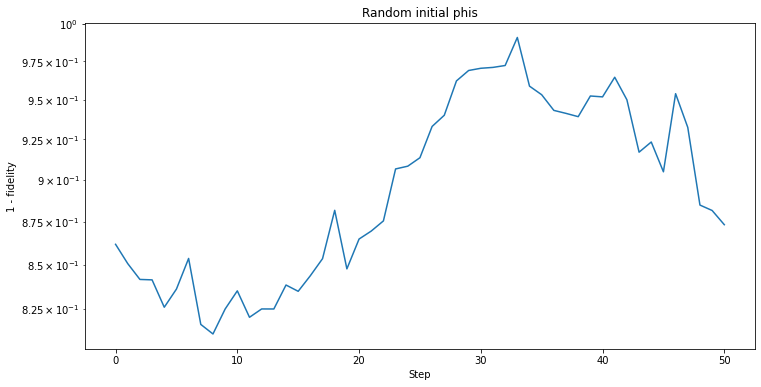

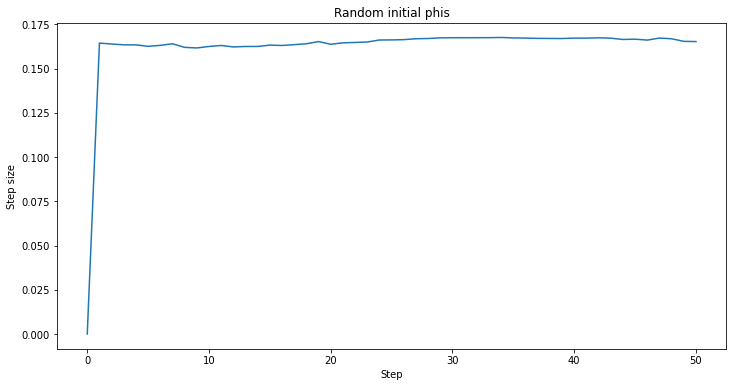

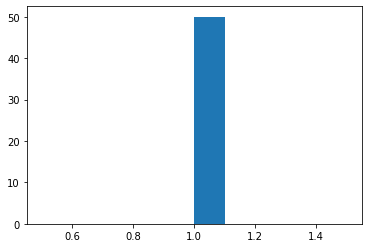

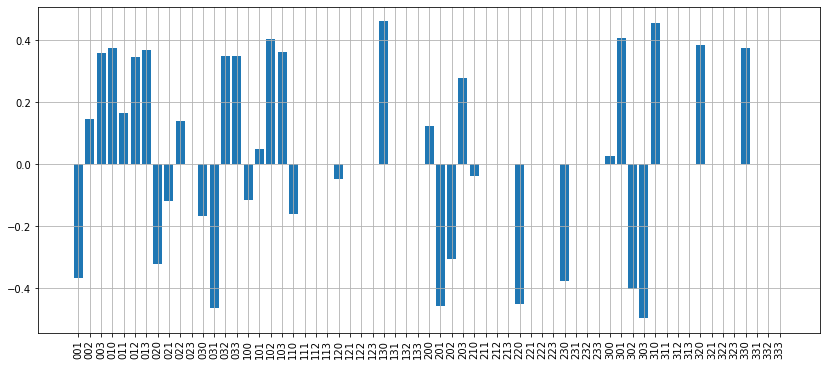

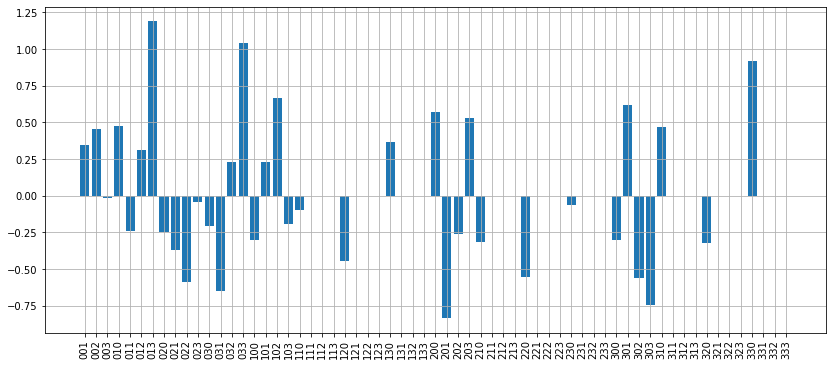

In [739]:
nqubits=3
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 1

multi_fidelities = []
multi_steps = []
multi_step_sizes = []
multi_indices = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices, step_sizes = rand_init_fidelities(Vqft, basis_full, num_steps=50, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_step_sizes.append(step_sizes)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
plot_multi_step_sizes(multi_steps, multi_step_sizes, title="Random initial phis")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[0])
plot_parameters(basis_full["labels"],phis[-1])

In [ ]:
plot_parameters(basis_full["labels"],parameters_from_hamiltonian(-1.j*spla.logm(Vqft), basis_full["basis"]))

Final fidelity = 0.91892830786964875077997] Omega geodesic gave a negative fidelity update for this step. Going perpendicular...                                             


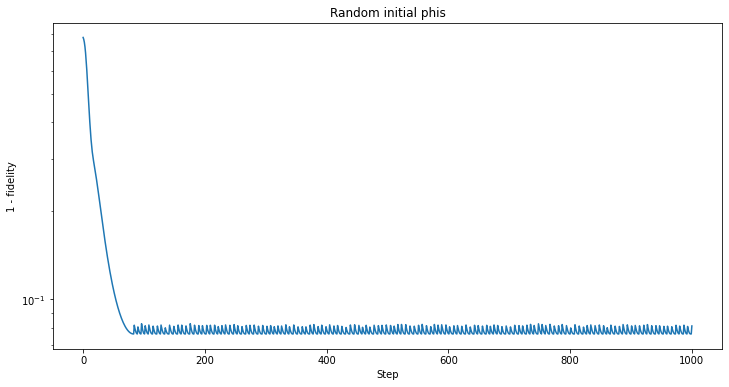

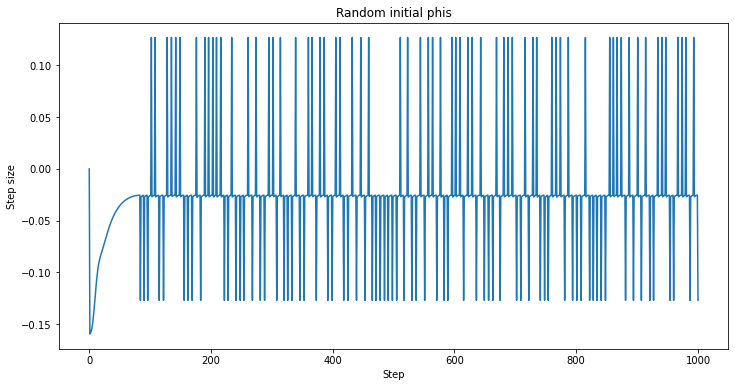

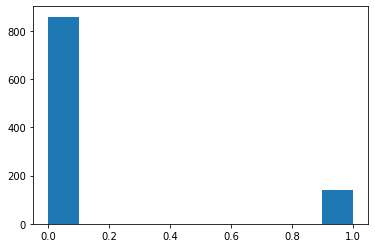

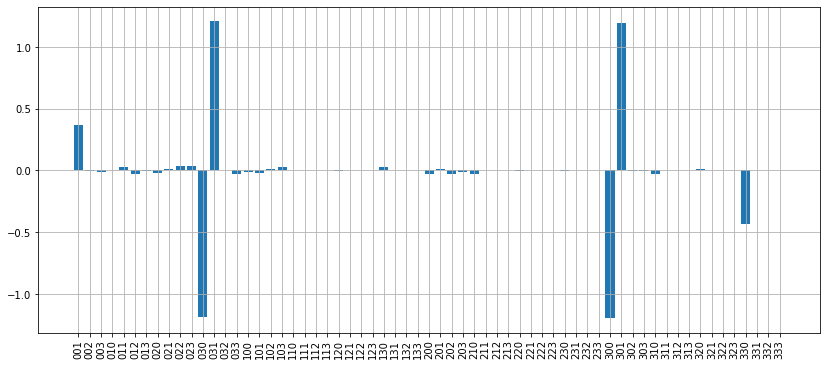

In [694]:
nqubits=3
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 1

multi_fidelities = []
multi_steps = []
multi_step_sizes = []
multi_indices = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices, step_sizes = rand_init_fidelities(Vtoff, basis_full, num_steps=1000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_step_sizes.append(step_sizes)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
plot_multi_step_sizes(multi_steps, multi_step_sizes, title="Random initial phis")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])

[19/1500] [Fidelity = 0.9806584585685718] Omega geodesic gave a positive fidelity update for this step...                                                                   
[20/1500] Solution found!
Final fidelity = 0.9994099841468826


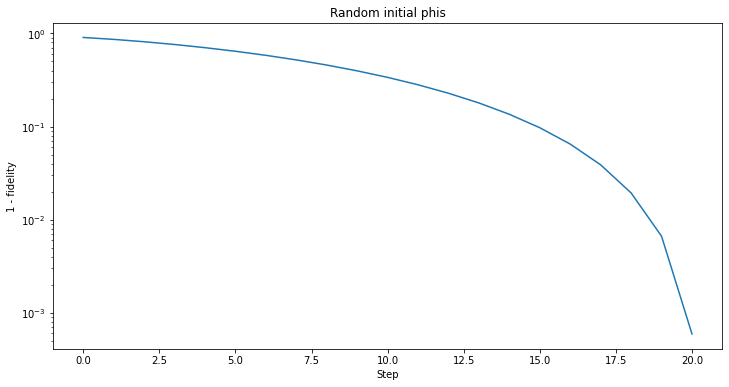

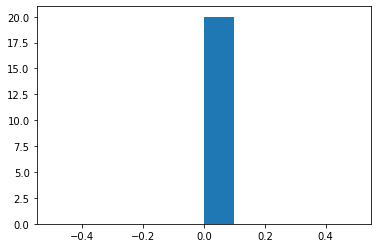

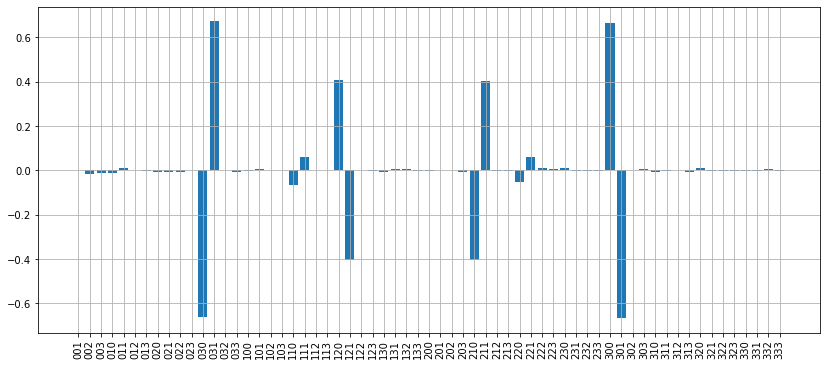

In [677]:
nqubits=3
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 1

multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices, step_sizes = rand_init_fidelities(VparityZ2, basis_full, num_steps=1500, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])

In [54]:
nqubits=5
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 1

multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices = rand_init_fidelities(VparityZ, basis_full, num_steps=20000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])

KeyboardInterrupt: 